In [1]:
from whoosh.index import create_in
from whoosh.fields import *
from whoosh.analysis import *
from whoosh.qparser import *
from whoosh import scoring
from whoosh import *
from whoosh.writing import AsyncWriter
import csv
import time
import os
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from Eval_metrics import * #my script .py with the implementation of the eval metrics
import random

In [2]:
def readfile(filename):
    tsv_file = open(filename)
    read_tsv = csv.reader(tsv_file, delimiter="\t")
    return list(read_tsv)

In [11]:
''' Define a function to convert the html file into csv'''
def converter():
    #path to the html files for the Time_DATASET
    path_Time = os.getcwd()+ "\part_1\part_1_1\Time_DATASET\DOCUMENTS\_" 
    #initialization of the dataframe for the time csv
    time_df=pd.DataFrame(columns=['ID','body']) 
    #for each doc in the folder Time_DATASET
    for j in range(1,423): 
        #define the file name
        filename2=path_Time+'_'*5+str(j)+'.html' 
        #open the file in reading mode
        with open(filename2) as f:
            content = f.read() 
        #use a html parser to pick the content of the file 
        soup = BeautifulSoup(content, 'html.parser')
        # save the body
        body=soup.body.string 
        #store into the dataframe the content. Each row of the document df is a .html file
        time_df=time_df.append({'ID':j,'body':body},ignore_index=True) 
    return time_df

In [12]:
# save the doc from Time dataset into csv file format
doc_Time_converted = converter()
doc_Time_converted.to_csv(os.getcwd()+"\part_1\part_1_1\Time_DATASET\Time_to_index.csv")

In [26]:
'''DEFINE THE FIRST PART OF THE SOFTWARE FOR THE SE'''
def sw_1(analyzer,filename):
    # creating schema with fields id and content
    schema = Schema(id=ID(stored=True),content=TEXT(stored=False, analyzer=analyzer))
    directory_containing_the_index = os.getcwd()+"\part_1\part_1_1\Time_DATASET" 
    # create an empty-index according to the just defined schema in the directory where csv file is
    ix = create_in(directory_containing_the_index, schema) 
    # open the index file
    ix = index.open_dir(directory_containing_the_index) #open the index file 
    writer =  AsyncWriter(ix) #define a writer object to add content to the fields
    # fill the index:
    ALL_DOCUMENTS_file_name = filename #path of the file 
    # open the file
    in_file = open(ALL_DOCUMENTS_file_name, "r", encoding='latin1')
    # read it as csv
    csv_reader = csv.reader(in_file, delimiter=',')  
    # to skip the header: first line contains the name of each field.
    csv_reader.__next__()
    # for each row in the 'doc_to_index' file 
    for record in csv_reader: 
        id = record[1] # extract the id doc
        content = record[2] # extract the body
        # add this new doc into the inverted index according to the schema
        writer.add_document(id=id, content=' '+content)
    # commit all the operations on the file
    writer.commit()
    # close the file
    in_file.close()

In [27]:
''' DEFINE THE QUERY ENGINE (THE SECOND PART OF THE SOFTWARE FOR THE SE)'''
def sw_2(analyzer,score_fun,input_query,max_number_of_results):
    directory_containing_the_index = os.getcwd()+"\part_1\part_1_1\Time_DATASET" 
    # thanks to the ix we can retreive doc of interest for the given SE configurations
    ix = index.open_dir(directory_containing_the_index) 
    # define a QueryParser for parsing the input_query
    qp = QueryParser("content", ix.schema)
    # apply it on the given query
    parsed_query = qp.parse(input_query) 
    # create a Searcher for the Index with the given scoring function 
    searcher = ix.searcher(weighting=score_fun) 
    # store results of the query and limiting max number of results
    results = searcher.search(parsed_query,limit=max_number_of_results) 
    # define a dataframe to store the results 
    result=pd.DataFrame() 
    row=pd.DataFrame()
    for hit in results:
        row=pd.DataFrame([str(hit.rank) , int(hit['id']), str(hit.score)]).T
        result=result.append(row)
    result.columns=["Rank" , "Doc_ID" , "Score"] 
    # the column 'score' contains the values of the scoring function, that we use for having in a quantitative way the relevance of a doc for a particulare query
    searcher.close()
    return result

In [29]:
'''
Method that given the specific SE configuration(analyzer,score_fun)
executes and returns the results for ALL the queries 
input:
    analyzer - selected text analyzer from the whoosh library
    score_fun - selected scoring function from the whoosh library
output: result - dataframe with the results of the given SE for ALL the queries; columns of df: ["Rank" , "Doc_ID" , "Score"]
''' 
def executor(analyzer,score_fun):
    result1=pd.DataFrame() # dataframe with the results of the given SE for ALL the queries; 
    tmp1=pd.DataFrame() #tmp dataframe 
    
    # open the file with all the queries
    Queries_file1= readfile(r"C:\Users\Stefania\DMT_HW1\part_1\part_1_1\Time_DATASET\time_Queries.tsv")
    Queries=pd.DataFrame(Queries_file1[1:],columns=['Query_ID','Query'])
    
    # open the file of the GT
    gt_csv = readfile(r"C:\Users\Stefania\DMT_HW1\part_1\part_1_1\Time_DATASET\time_Ground_Truth.tsv")
    gt1 = pd.DataFrame(gt_csv[1:],columns=['Query_id','Relevant_Doc_id'])

    #define a list with the unique query ids
    Q1=list(gt1['Query_id'].unique()) 
    dq1={} #key=Query_id, value=number of relevant documents related to that query_id
    for i in Q1: # for each query_id
        dq1[i]=len(list(gt1[gt1['Query_id']==i]['Relevant_Doc_id']))

    file_toindex1=os.getcwd()+"\part_1\part_1_1\Time_DATASET\Time_to_index.csv"
    # invoke the function to create the schema and to store the index file based on the retrieved 'doc_to_index.csv' file  
    sw_1(analyzer,file_toindex1)
    # for each index in the query set
    for i in Q1:
        # store the number of relevant documents related to the specific input query
        max_number_of_results_1q=dq1[i] #count_of_vals(dq,i)
        if max_number_of_results_1q==0:
            max_number_of_results_1q=1
        # invoke the function that,given the input query and given the specific SE configuration,
        # returns the results of the search and store it into a tmp dataframe
        tmp1=sw_2(analyzer,score_fun,list(Queries[Queries['Query_ID']==i]['Query'])[0],max_number_of_results_1q)
        tmp1['Query_id']=i
        result1=result1.append(tmp1) #then for each query add it to the result dataframe 
    return result1

In [30]:
# Score based on position (by Whoosh documentation)
def pos_score_fn(searcher, fieldname, text, matcher):
    poses = matcher.value_as("positions")
    return 1.0 / (poses[0] + 1)

In [31]:
def search_engine():
    # open the ground truth
    gt_csv = readfile(r"C:\Users\Stefania\DMT_HW1\part_1\part_1_1\Time_DATASET\time_Ground_Truth.tsv")
    gt1 = pd.DataFrame(gt_csv[1:],columns=['Query_id','Relevant_Doc_id'])

    list_mrr1=[] # to store the MRR values for each SE configuration 
    # define the scoring functions
    score_functions = [scoring.FunctionWeighting(pos_score_fn),scoring.PL2(),scoring.BM25F(B=0.75, content_B=1.0, K1=1.5)]
    # define the text analyzers
    analyzers = [StemmingAnalyzer(),FancyAnalyzer(),LanguageAnalyzer('en')]
    #combinations for every chosen analyzer with every chosen scoring function
    num_analyzers = len(analyzers)
    num_score_fun = len(score_functions)
    i=1
    sel_ana=['StemmingAnalyzer()','FancyAnalyzer()','LanguageAnalyzer()']
    scor_func=[' FunctionWeighting',' PL2',' BM25F']
    for x in range(num_analyzers):
        for y in range(num_score_fun):
            print(sel_ana[x]+scor_func[y])
            # execute queries with the chosen configuration
            sr_1=executor(analyzers[x],score_functions[y]) 
            #save results of the search engine
            sr_1.to_csv(os.getcwd()+"\part_1\part_1_1\Time_DATASET"+str(i)+".csv",index=False) 
            
            #open the file and compute the MRR
            file_sr = open(r"C:\Users\Stefania\DMT_HW1\part_1\part_1_1\Time_DATASET"+str(i)+".csv")
            se_csv = list(csv.reader(file_sr, delimiter=","))
            sr = pd.DataFrame(se_csv[1:],columns=['Rank','Doc_ID','Score','Query_id'])
            
            list_mrr1.append((sel_ana[x]+scor_func[y],MRR(sr,gt1))) 
            i+=1
    # save into a table with MRR evaluation for every search engine configuration 
    mrrs=pd.DataFrame(list_mrr1)
    mrrs.to_csv(os.getcwd()+"\part_1\part_1_1\Time_DATASET\mrr.csv", index=False) #store MRR table

In [32]:
# exec the search engine with the different configurations for the Time dataset
search_engine()

StemmingAnalyzer() FunctionWeighting
StemmingAnalyzer() PL2
StemmingAnalyzer() BM25F
FancyAnalyzer() FunctionWeighting
FancyAnalyzer() PL2
FancyAnalyzer() BM25F
LanguageAnalyzer() FunctionWeighting
LanguageAnalyzer() PL2
LanguageAnalyzer() BM25F


In [3]:
#CREATE THE TABLE OF DISTRIBUTION 
def r_distribution(num_configuration): # 'num_configuration' to change if the config changes
    # compute the r-precision eval metric on the SE config
    gt_csv = readfile(r"C:\Users\Stefania\DMT_HW1\part_1\part_1_1\Time_DATASET\time_Ground_Truth.tsv")
    gt = pd.DataFrame(gt_csv[1:],columns=['Query_id','Relevant_Doc_id'])
    
    r_list = []
    for i in range(1,num_configuration+1): 
        #read the SE results for the time dataset
        file_se = open(r"C:\Users\Stefania\DMT_HW1\part_1\part_1_1\Time_DATASET"+ str(i)+".csv")
        se_csv = list(csv.reader(file_se, delimiter=","))
        sr = pd.DataFrame(se_csv[1:],columns=['Rank','Doc_ID','Score','Query_id'])
        
        r_list.append(r_precision(sr,gt))
    #store the result into a df
    R_precision = pd.DataFrame(r_list)
    R_precision.index = np.arange(1, len(R_precision)+1) #reset the index and start from 1

    # Do the r-precision distribution table for each configuration in the Cranfield dataset
    metric= [R_precision.mean(axis=1),R_precision.min(axis=1),R_precision.quantile(0.25,axis=1),R_precision.median(axis=1),R_precision.quantile(0.75,axis=1),R_precision.max(axis=1)]
    r_distr = pd.DataFrame(metric).T
    #set the cols name
    r_distr.columns=['Mean','Min','1°_quartile','Median','3°_quartile','Max']
    #add a column to indicate the SE configuration
    configs = ['conf_1','conf_2','conf_3','conf_4','conf_5','conf_6','conf_7','conf_8','conf_9']
    r_distr['SE_Config'] = configs
    r_distri = r_distr[['SE_Config','Mean','Min','1°_quartile','Median','3°_quartile','Max']]
    r_distri.index = np.arange(1, len(configs)+1) #reset the index and start from 1
    return r_distri

#invoke the function and save the df into a csv file
r_pr_distr = r_distribution(9) 
r_pr_distr.to_csv('part_1\part_1_1\Time_DATASET\R_precision_distribution.csv') 

In [4]:
r_pr_distr

,SE_Config,Mean,Min,1°_quartile,Median,3°_quartile,Max
1,conf_1,0.276361,0.0,0.0,0.129167,0.500000,1.0
2,conf_2,0.482691,0.0,0.0,0.500000,0.808333,1.0
3,conf_3,0.542521,0.0,0.2,0.516667,0.888889,1.0
4,conf_4,0.279868,0.0,0.0,0.183333,0.500000,1.0
5,conf_5,0.475147,0.0,0.0,0.500000,0.808333,1.0
6,conf_6,0.529413,0.0,0.2,0.500000,0.888889,1.0
7,conf_7,0.270299,0.0,0.0,0.125000,0.500000,1.0
8,conf_8,0.497671,0.0,0.0,0.500000,0.800000,1.0
9,conf_9,0.544307,0.0,0.2,0.516667,0.916667,1.0


In [5]:
# select the top 5 configuration according to the MRR
def top_five(mrr):
    mrr.index = np.arange(1, len(mrr)+1) #reset a index
    top = mrr.sort_values(by = ['MRR'],ascending=False).head(5)
    top_five = top.index
    return top_five

file_MRR = open(r"C:\Users\Stefania\DMT_HW1\part_1\part_1_1\Time_DATASET\mrr.csv")
MRR_csv = list(csv.reader(file_MRR, delimiter=","))
mrr_time = pd.DataFrame(MRR_csv[1:])
mrr_time.columns = ['Config','MRR'] #add cols name
mrr_time = mrr_time.astype({"MRR": float}) #change type of the column into float
top_conf = top_five(mrr_time)
top_five = list(top_conf)

In [6]:
top_five

[9, 3, 6, 8, 2]

In [132]:
#P@k with top 5
def p_topfive(top,k):
    p_at_k_list =[]
    gt_csv = readfile(r"C:\Users\Stefania\DMT_HW1\part_1\part_1_1\Time_DATASET\time_Ground_Truth.tsv")
    gt = pd.DataFrame(gt_csv[1:],columns=['Query_id','Relevant_Doc_id'])
    
    for i in top:
        #read the SE results for the time dataset
        file_se = open(r"C:\Users\Stefania\DMT_HW1\part_1\part_1_1\Time_DATASET"+ str(i)+".csv")
        se_csv = list(csv.reader(file_se, delimiter=","))
        sr = pd.DataFrame(se_csv[1:],columns=['Rank','Doc_ID','Score','Query_id'])
        
        p_at_k_list.append(p_at_k(sr,gt,k))
    return p_at_k_list

k_list = [1, 3, 5, 10]
output=[]
for k in k_list:
    output.append(p_topfive(top_five,k))
p_at_k_df = pd.DataFrame(output)
p_at_k_df.index = k_list
p_at_k_df.columns = ['SE_9','SE_3','SE_6','SE_8','SE_2'] #TOP 5 SE configuration

In [133]:
p_at_k_df

,SE_9,SE_3,SE_6,SE_8,SE_2
1,0.600000,0.600000,0.512500,0.512500,0.512500
3,0.556250,0.552083,0.535417,0.529167,0.508333
5,0.562083,0.564583,0.546250,0.515833,0.508333
10,0.548125,0.546895,0.534415,0.503700,0.489415


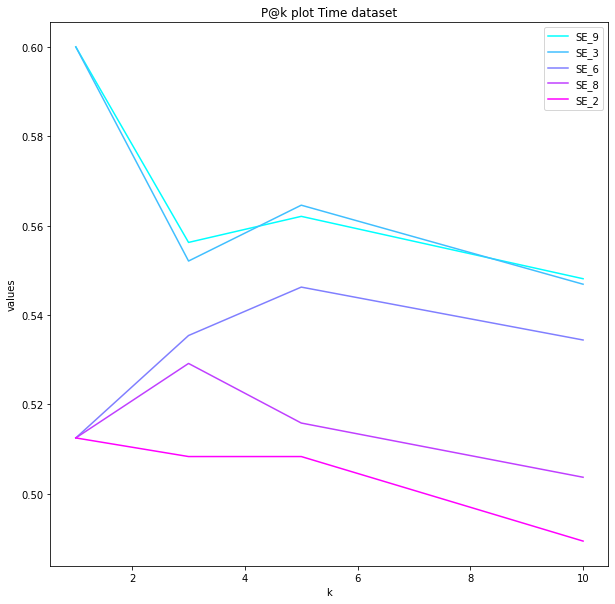

In [135]:
plot1 = p_at_k_df.plot(y=['SE_9','SE_3','SE_6','SE_8','SE_2'],colormap="cool",\
              xlabel="k", ylabel="values",figsize=(10,10), title = 'P@k plot Time dataset').get_figure();
plot1.savefig('Time_p_plot.jpg')

In [208]:
# normalized Discounted Cumulative Gain (nDCG)
def n_dcg(se,gt,k):
    rel=0
    dcg=0
    idcg=0
    ndcg=[]
    Q=set(gt['Query_id'].unique())
    for i in Q:
        seID = se['Doc_ID'].loc[se['Query_id'] == i].tolist()
        gtID = gt['Relevant_Doc_id'].loc[gt['Query_id'] == i].tolist()
        for el in gtID:
            for it in seID[:k]:
                rel=1 if it==el else 0
        for p in range(1,k+1):
            dcg+=rel/(math.log2(p+1))
            idcg+=1/(math.log2(p+1))
        ndcg.append(dcg/idcg)
    return (mean(ndcg))

In [209]:
#nDCG with top 5
def ndcg_topfive(top,k):
    ndcg_list =[]
    gt_csv = readfile(r"C:\Users\Stefania\DMT_HW1\part_1\part_1_1\Time_DATASET\time_Ground_Truth.tsv")
    gt = pd.DataFrame(gt_csv[1:],columns=['Query_id','Relevant_Doc_id'])
    
    for i in top:
        #read the SE results for the time dataset
        file_se = open(r"C:\Users\Stefania\DMT_HW1\part_1\part_1_1\Time_DATASET"+ str(i)+".csv")
        se_csv = list(csv.reader(file_se, delimiter=","))
        sr = pd.DataFrame(se_csv[1:],columns=['Rank','Doc_ID','Score','Query_id'])
        
        ndcg_list.append(n_dcg(sr,gt,k))
    return ndcg_list

k_list = [1, 3, 5, 10]
output_ndcg=[]
for k in k_list:
    output_ndcg.append(ndcg_topfive(top_five,k))
ndcg_df = pd.DataFrame(output_ndcg)
ndcg_df.index = k_list
ndcg_df.columns = ['SE_9','SE_3','SE_6','SE_8','SE_2'] #TOP 5 SE configuration

In [210]:
ndcg_df

,SE_9,SE_3,SE_6,SE_8,SE_2
1,0.254257,0.256646,0.278669,0.193926,0.159688
3,0.283995,0.295565,0.304753,0.256611,0.253632
5,0.313950,0.294445,0.258723,0.245384,0.231446
10,0.336029,0.284606,0.280327,0.267464,0.222083


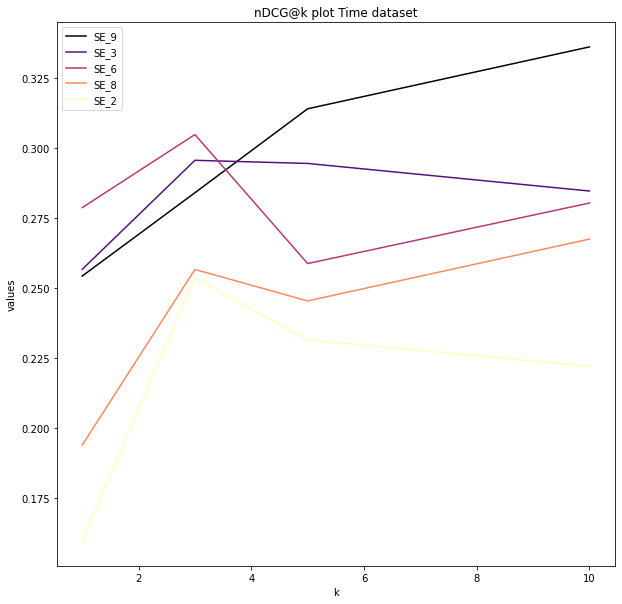

In [211]:
plot2 = ndcg_df.plot(y=['SE_9','SE_3','SE_6','SE_8','SE_2'],colormap="magma",\
            xlabel="k", ylabel="values",figsize=(10,10), title = 'nDCG@k plot Time dataset').get_figure();
#plot2.savefig('ndcg_plot.jpg')